In [1]:
import sys
sys.path.append('/home/npopkov/dll24')

import matplotlib.pyplot as plt
import torch
torch.backends.cudnn.benchmark = True

import numpy as np
import lightning as lt
torch.set_float32_matmul_precision('medium')
import soundfile as sf

from audio_diffusion_pytorch import DiffusionModel, UNetV0, VDiffusion, VSampler

from torch.utils.data import DataLoader,Dataset

import h5py
from tqdm.auto import tqdm

class SnippetDatasetHDF(Dataset):
    def __init__(self, hdf, scaling='minmax'):
        self.num_rows = 0
        self.size = int(3.4*24000)
        self.scaling = scaling
        self.data = self.createData(hdf)
        
        if scaling == 'standard':
            self.mean = self.data.mean()
            self.std =  self.data.std()
            self.data = (self.data - self.mean) / self.std
        
        if scaling == 'minmax':
            self.min = self.data.min()
            self.max = self.data.max()
            self.data = (self.data - self.min) / (self.max - self.min)
    
    def __len__(self):
        return self.num_rows
    
    def __getitem__(self, idx):
        return self.data[idx]
    
    def createData(self, hdf):
        data = []
        keys = list(hdf.keys())
        self.num_rows = len(keys)
        for key in tqdm(keys):
            sample = hdf[key]['audio'][:]
            if len(sample) > self.size:
                self.num_rows -= 1
                continue

            if len(sample) < self.size:
                sample = np.pad(sample, (0, self.size - len(sample)), 'constant')

            data.append(sample)
         
        return torch.tensor(np.array(data)).float()

    def retransform(self, data):
        if self.scaling == 'standard':
            return data * self.std + self.mean
        if self.scaling == 'minmax':
            return data * (self.max - self.min) + self.min

hdf = h5py.File('../../../test_24k.hdf5', 'r')
dataset = SnippetDatasetHDF(hdf)
hdf.close()



/home/npopkov/dll24/.conda/lib/python3.9/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm
100%|██████████| 6675/6675 [00:03<00:00, 2024.50it/s]


In [2]:
import dac
from audiotools import AudioSignal
import torchaudio
import torch


dac_model_path = dac.utils.download(model_type='24kHz')
dac_model = dac.DAC.load(dac_model_path)

# Load and pre-process the audio waveform
signal = AudioSignal(dataset.retransform(dataset[0]),sample_rate=24000)


wav_dac = dac_model.preprocess(signal.audio_data, signal.sample_rate)
z, codes, latents,_,_ = dac_model.encode(wav_dac)
latents = torch.nn.functional.pad(latents, (0, 1))

from_latent_dac,_,_ = dac_model.quantizer.from_latents(latents)
rebuild_dac = dac_model.decode(from_latent_dac)


/home/npopkov/dll24/.conda/lib/python3.9/site-packages/torch/nn/utils/weight_norm.py:30: UserWarning: torch.nn.utils.weight_norm is deprecated in favor of torch.nn.utils.parametrizations.weight_norm.
  warnings.warn("torch.nn.utils.weight_norm is deprecated in favor of torch.nn.utils.parametrizations.weight_norm.")


In [3]:
latents.shape

torch.Size([1, 256, 256])

In [4]:
rebuild_dac.shape

torch.Size([1, 1, 81912])

In [5]:
float_codes = codes.float()
float_codes

tensor([[[ 326.,  326.,  326.,  ...,  910.,  910.,  910.],
         [ 810.,  612.,  240.,  ...,  496.,  658.,  496.],
         [ 221.,   80.,  728.,  ...,  385.,  661.,  497.],
         ...,
         [ 571.,  161., 1010.,  ...,  970., 1008.,  712.],
         [ 779.,  905.,  470.,  ...,  670.,  930.,  348.],
         [  84.,  567.,   11.,  ...,  443.,  246.,  481.]]])

(-0.5, 255.5, -0.5, 255.5)

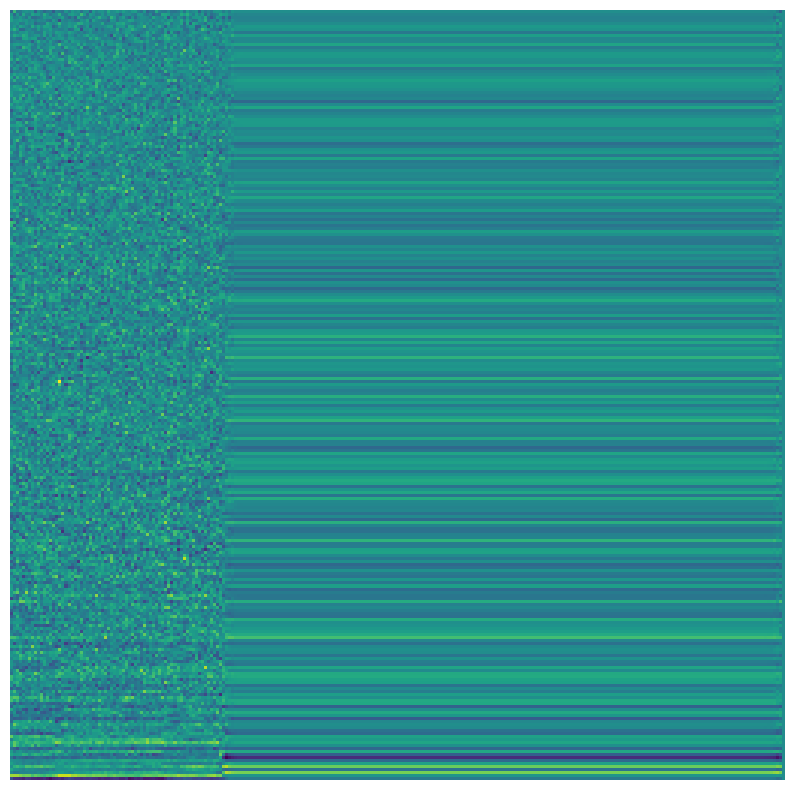

In [6]:
plt.figure(figsize=(10, 10))
plt.imshow(latents.squeeze().detach().cpu().numpy(), aspect='auto', origin='lower')
plt.axis('off')

(0.0, 24000.0, -0.1, 0.1)

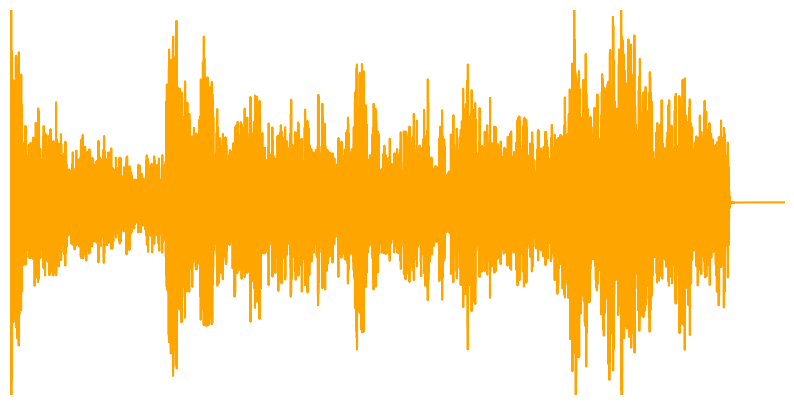

In [7]:
plt.figure(figsize=(10, 5))
plt.plot(rebuild_dac.squeeze().detach().cpu().numpy(), label='rebuild',color='orange')
plt.xlim(0, 24000)
plt.ylim(-.1, .1)
plt.xticks([])
plt.grid()
plt.axis('off')

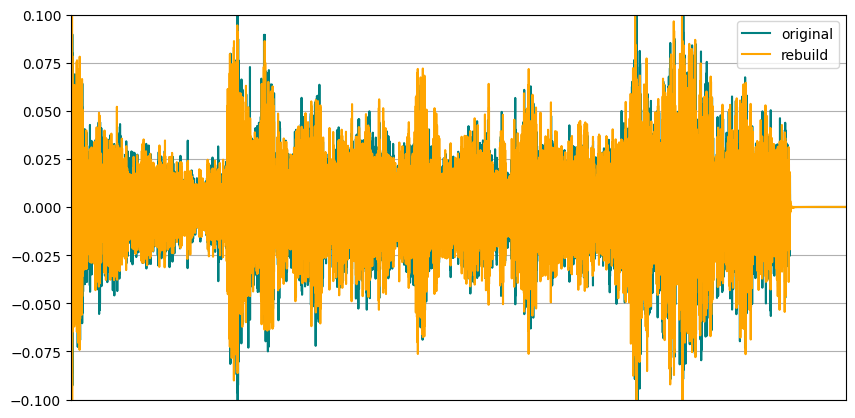

In [11]:
plt.figure(figsize=(10, 5))
plt.plot(signal.audio_data.squeeze(), label='original',color='teal')
plt.plot(rebuild_dac.squeeze().detach().cpu().numpy(), label='rebuild',color='orange')
plt.xlim(0, 24000)
plt.ylim(-.1, .1)
plt.xticks([])
plt.grid()
plt.legend()

In [26]:
import h5py

#Create a new HDF file
output_file = 'dac_latent_samples_256.hdf5'
hdf_output = h5py.File(output_file, 'w')

#Encode and store each sample in the HDF file
for i in tqdm(range(len(dataset))):
   sample = dataset.retransform(dataset[i])
   signal = AudioSignal(sample,sample_rate=24000)


   wav_dac = dac_model.preprocess(signal.audio_data, signal.sample_rate)
   z, codes, latents,_,_ = dac_model.encode(wav_dac)
   latents = torch.nn.functional.pad(latents, (0, 1))
   hdf_output.create_dataset(f'sample_{i}', data=latents.squeeze().detach().cpu().numpy())

#Close the HDF file
hdf_output.close()

#Print the path of the output file
print(f"Encoded samples saved to: {output_file}")

  2%|▏         | 93/5756 [00:23<23:36,  4.00it/s]


KeyboardInterrupt: 

In [25]:
hdf_output.close()
